In [4]:
import tensorflow as tf

import numpy as np



from qutip.visualization import plot_wigner_fock_distribution
from qutip.wigner import qfunc
from qutip import fidelity, coherent_dm, Qobj, expect
from qutip.states import fock_dm
from qutip.random_objects import rand_dm

import matplotlib.pyplot as plt



from qst_cgan.ops import (random_alpha, dm_to_tf, batched_expect, convert_to_real_ops)
from qst_cgan.gan import Generator, Discriminator

from qst_cgan.ops import convert_to_real_ops, batched_expect, tf_fidelity
from qst_cgan.gan import generator_loss, discriminator_loss, Generator, Discriminator

import pickle

from qst_nn.utils import plot_three_fock, plot_three_husimi, plot_all_fidelities, cat
from dataclasses import dataclass


from tqdm.auto import tqdm

tf.keras.backend.set_floatx('float64')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {# 'backend': 'ps',
          'axes.labelsize': 8,
          'font.size': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.labelpad': 1,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

In [6]:
hilbert_size = 32
# Betas can be selected in a grid or randomly in a circle
num_grid = 32

beta_max = 5
mixing = 0.8

psi = cat(hilbert_size, 2, 0, 0)
rho = psi*psi.dag()

# Define functions to get measurement operators (Husimi Q functions)

100%|██████████| 256/256 [00:01<00:00, 192.48it/s]


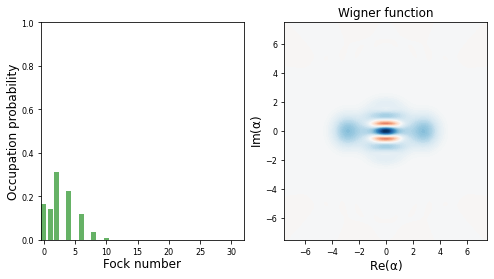

In [7]:
def husimi_ops(hilbert_size, betas):
    """
    Constructs a list of measurement operators for the Wigner function
    measurement at beta values.
    
    Args:
        hilbert_size (int): The hilbert size dimension for the operators
        betas (list/array): N complex values to construct the operator
        
    Returns:
        ops_list (list): A list of (N, hilbert_size, hilbert_size) for N ops
    """
    ops_list = []
    
    for beta in tqdm(betas):
        op = coherent_dm(hilbert_size*2, beta)
        op = Qobj(op[:hilbert_size, :hilbert_size])
        ops_list.append(op)

    return ops_list


def mix(rho, mixing=1, rank=1):
    mixes = [fock_dm(hilbert_size, i) for i in range(rank - 1)]
    mixed_state = mixing*(rho) + (1 - mixing)*(sum(mixes))
    mixed_state = mixed_state.unit()
    return mixed_state


num_points = 256
rank = 4

rho_mixed = mix(rho, mixing, rank)
plot_wigner_fock_distribution(rho_mixed)


rand_betas = [random_alpha(beta_max) for i in range(num_points)]
m_ops = husimi_ops(hilbert_size, rand_betas)

# Train the CGAN

In [8]:
ops_numpy = [op.data.toarray() for op in m_ops] # convert the QuTiP Qobj to numpy arrays
ops_tf = tf.convert_to_tensor([ops_numpy]) # convert the numpy arrays to complex TensorFlow tensors
A = convert_to_real_ops(ops_tf)

rho_numpy = rho_mixed.data.toarray().reshape((1, hilbert_size, hilbert_size)) # Conversion to NumPy array and reshaping into (1, N, N) to allow batching
rho_tf = tf.complex(rho_numpy.real, rho_numpy.imag)

x = batched_expect(ops_tf, rho_tf)
num_measurements = x.shape[-1]

2021-09-24 18:26:22.788407: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
tf.keras.backend.clear_session()


generator = Generator(hilbert_size, num_measurements, noise=0.) # Specify the number of measurement settings and Gaussian noise
discriminator = Discriminator(hilbert_size, num_measurements)

In [21]:
density_layer_idx = None

for i, layer in enumerate(generator.layers):
    if "density_matrix" in layer._name:
        density_layer_idx = i
        break


model_dm = tf.keras.Model(inputs=generator.input, outputs=generator.layers[density_layer_idx].output)

@dataclass
class LossHistory:
    """Class for keeping track of loss"""
    generator: list
    discriminator: list
    l1: list

loss = LossHistory([], [], [])
fidelities = []

initial_learning_rate = 0.0002

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                             decay_steps=10000,
                                                             decay_rate=.96,
                                                             staircase=False)

lam = 1.

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)

max_iterations = 500

def train_step(A, x):
    """Takes one step of training for the full A matrix representing the
    measurement operators and data x.

    Note that the `generator`, `discriminator`, `generator_optimizer` and the
    `discriminator_optimizer` has to be defined before calling this function.

    Args:
        A (tf.Tensor): A tensor of shape (m, hilbert_size, hilbert_size, n x 2)
                       where m=1 for a single reconstruction, and n represents
                       the number of measured operators. We split the complex
                       operators as real and imaginary in the last axis. The 
                       helper function `convert_to_real_ops` can be used to
                       generate the matrix A with a set of complex operators
                       given by `ops` with shape (1, n, hilbert_size, hilbert_size)
                       by calling `A = convert_to_real_ops(ops)`.

        x (tf.Tensor): A tensor of shape (m, n) with m=1 for a single
                       reconstruction and `n` representing the number of
                       measurements. 
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([A, x], training=True)

        disc_real_output = discriminator([A, x, x], training=True)
        disc_generated_output = discriminator([A, x, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, x, lam=lam
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

    loss.generator.append(gen_gan_loss)
    loss.l1.append(gen_l1_loss)
    loss.discriminator.append(disc_loss)



pbar = tqdm(range(max_iterations))
for i in pbar:
    train_step(A, x)
    density_matrix = model_dm([A, x])
    dm_reconstructed = Qobj(density_matrix.numpy()[0].reshape(hilbert_size, hilbert_size))
    f = fidelity(dm_reconstructed, rho_mixed)
    fidelities.append(f)
    pbar.set_description("Fidelity {} | Gen loss {} | L1 loss {} | Disc loss {}".format(f, loss.generator[-1], loss.l1[-1], loss.discriminator[-1]))

Fidelity 0.9061230111373161 | Gen loss 0.6933907866477966 | L1 loss 0.0035851119056237737 | Disc loss 1.3862982988357544: 100%|██████████| 500/500 [01:03<00:00,  7.87it/s]


# Train iMLE

In [22]:
data = expect(m_ops, rho_mixed)

fidelities_imle = []
max_iterations = 10000

rho_imle = rand_dm(hilbert_size, 0.8)
fidelities_imle.append(fidelity(rho, rho_imle))
pbar = tqdm(range(max_iterations))

print(fidelities_imle)

  0%|          | 0/10000 [00:00<?, ?it/s]

[0.16721496680781253]


In [23]:
for i in range(max_iterations):
    guessed_val = expect(m_ops, rho_imle)
    ratio = data / guessed_val

    R = Qobj(np.einsum("aij,a->ij", ops_numpy, ratio))
    rho_imle = R * rho_imle * R
    rho_imle = rho_imle / rho_imle.tr()

    f = fidelity(rho_imle, rho)
    fidelities_imle.append(f)

    pbar.set_description("Fidelity iMLE {:.4f}".format(f))
    pbar.update()

Fidelity iMLE 0.4051:  23%|██▎       | 2309/10000 [00:49<02:54, 44.04it/s]

KeyboardInterrupt: 

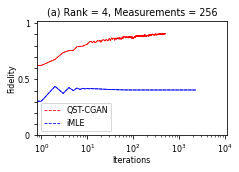

In [24]:
fig, ax = plot_all_fidelities([fidelities], x=np.arange(0, len(fidelities)), label="QST-CGAN", show_mean=True)
plot_all_fidelities([fidelities_imle], x=np.arange(0, len(fidelities_imle)), fig=fig, ax=ax, color="b",
                    label="iMLE", title="(a) Rank = 4, Measurements = {}".format(num_points),
                    show_mean=True)
plt.legend()
# figpath="figures/"

/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:234: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0].pcolor(xvec, yvec, d1,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:238: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1].pcolor(xvec, yvec, d2,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:242: MatplotlibDeprecationWarning: shading='flat' when 

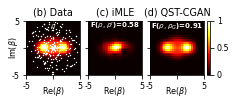

In [25]:
xvec = np.linspace(-5, 5, 32)
yvec = np.linspace(-5, 5, 32)

rho1  = rho_mixed
q1 = qfunc(rho1, xvec, yvec, g=2)

rho2 = rho_imle # imle_states[-1]
q2 = qfunc(rho2, xvec, yvec, g=2)


rho3 = dm_reconstructed
q3 = qfunc(rho3, xvec, yvec, g=2)


intext = [r"$\rho$",
          r"F($\rho, \rho'$)="+"{:.2f}".format(fidelity(rho1, rho2)),
          r"F($\rho, \rho_{G}$)="+"{:.2f}".format(fidelity(rho1, rho3))]

bbox=dict(boxstyle='square, pad=0.01', fc='None', ec='None')
fig, ax = plot_three_husimi(q1, q2, q3, cmap="hot",
                            subtitles=["(b) Data", "(c) iMLE", "(d) QST-CGAN"])
textcolor="w"
ax[0].text(0.5, 0.87, intext[0], bbox=bbox, ha='center',fontweight="bold",
      transform=ax[0].transAxes, fontsize=7, color=textcolor, )

for i in range(1,3):
    ax[i].text(0.5, 0.85, intext[i], bbox=bbox, ha='center',fontweight="bold",
          transform=ax[i].transAxes, fontsize=7, color=textcolor,)
ax[0].scatter(np.real(rand_betas), np.imag(rand_betas), marker="x", s=0.2, color="w")

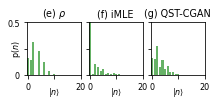

Fidelity iMLE 0.4051:  23%|██▎       | 2310/10000 [01:00<02:54, 44.04it/s]

In [26]:
fig, ax = plot_three_fock(rho1, rho2, rho3, subtitles=[r"(e) $\rho$", "(f) iMLE", "(g) QST-CGAN"])
figpath="figures/"